In [12]:
import numpy as np
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt
import pickle

from utils import create_vectors, encode_point
from region_query_utils import direction_quad, generate_rectangle_region, saccades, lookup_space_table, predict_single_query
import region_query_utils
import utils
from image_to_memory import encode_memory_shape, decode_image

#putting it all together

In [39]:
objs = ["ZERO", "ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX", "SEVEN", "EIGHT", "NINE"]
D = 512

_, vec_dic = create_vectors(objs, D)
X = vec_dic['X']
Y = vec_dic['Y']

In [4]:
n = 200 #number of images
m = 4 #digits per image (max 4 right now due to spread factor)

from mnist_image_generator import gen_images
image_data = gen_images(n,m)

xs_original = np.array(image_data['x'])
ys_original = np.array(image_data['y'])

In [47]:
d_chars = pickle.load(open('d_chars.pkl', 'rb'))
obj_dic = spa.Vocabulary(512)
for i,k in enumerate(objs):
    img = d_chars[str(i)]
    vec = region_query_utils.convert_pixels(img, X, Y, spa_range=[-5,5])
    obj_dic.add(k,spa.SemanticPointer(vec).normalized())
    

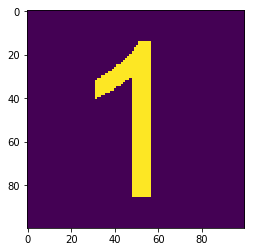

In [42]:
plt.imshow(d_chars['1'])

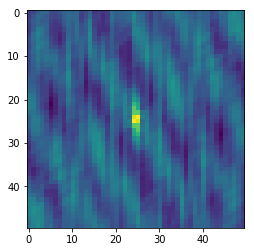

In [50]:
plt.imshow(utils.spatial_dot(obj_dic['ONE'] * ~ obj_dic['ONE'], np.linspace(-20,20), np.linspace(-20,20), X,Y, swap = True))

In [5]:
xs, ys = saccades(image_data['images'])
xs = np.array(xs)
ys = np.array(ys)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


In [6]:
import keras

im_dim = 28
model = keras.models.load_model('mnist_net.h5')

pred_obj_list = decode_image(image_data['images'], xs, ys, im_dim//2, model)

In [7]:
obj_vectors = np.array([obj_dic[_] for _ in objs])

square = generate_rectangle_region([-1,1],[-1,1], X,Y)
square.normalized()

# square = power(X,0)
#store objects in memory as squares rather than points
memory_data = encode_memory_shape(pred_obj_list, xs,ys, obj_vectors, [X,Y], square, n, m)
# memory_data = encode_memory(pred_obj_list, xs,ys, obj_vectors, [X,Y], n, m)

C:\ProgramData\Anaconda3\lib\site-packages\nengo_spa\semantic_pointer.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)


In [8]:
#get direction of second object towards first object
dirs = direction_quad(xs_original[:, 0] - xs_original[:, 1], ys_original[:, 0] - ys_original[:, 1])

In [9]:
from region_query_utils import predict_single_query, get_quads, generate_space_table

UP_RIGHT, DOWN_RIGHT, UP_LEFT, DOWN_LEFT = get_quads(X,Y, 5)
region_selector = np.array([[DOWN_LEFT, UP_LEFT],[DOWN_RIGHT, UP_RIGHT]])

loc_table = generate_space_table(np.linspace(-5, 5, 100),np.linspace(-5, 5, 100),D, X,Y)

In [10]:
obj_list = np.array(image_data['obj_list'])
query_obj = [obj_dic[objs[o]] for o in obj_list[:,1]]

In [11]:
preds = predict_single_query(memory_data['obj_loc_memory'], memory_data['obj_memory'], query_obj, dirs, obj_dic, region_selector, loc_table)

In [12]:
#Check if the predicted vector is in the correct direction (since multiple correct answers)

inregion_map = np.zeros((n, m))
for i in range(m):
    correct_dir_1 = np.all(np.array(dirs) == np.array(direction_quad(xs_original[:, i] - xs_original[:, 1], ys_original[:, i] - ys_original[:, 1])), axis=0)
    
    inregion_map[:,i] = correct_dir_1

inregion = np.where(inregion_map, obj_list, -1)

print(np.mean(np.any((inregion== preds[:,None]), axis = 1)))

0.735


In [13]:
np.where(np.any((inregion== preds[:,None]), axis = 1)==0)

(array([  0,   4,  16,  18,  22,  26,  31,  34,  36,  39,  41,  44,  46,
         48,  49,  50,  52,  57,  59,  66,  69,  73,  75,  81,  82,  87,
         91,  99, 101, 104, 110, 117, 119, 122, 126, 137, 140, 143, 145,
        148, 154, 155, 164, 165, 170, 171, 175, 177, 181, 183, 187, 189,
        199], dtype=int64),)

[5, array([5, 1, 7, 4], dtype=uint8)]

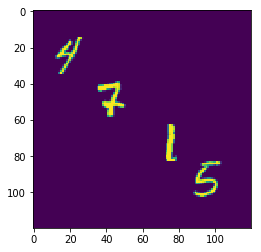

In [14]:
i =33
plt.imshow(image_data['images'][i])
[preds[i], obj_list[i]]